In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                            inter_op_parallelism_threads=16,
                            allow_soft_placement=True,
                            device_count={'CPU': 8,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

In [37]:
file_path = os.path.expanduser('~/ensemble_results.pkl')
with open(file_path,'rb') as f:
    data = pickle.load(f,encoding='latin1')

In [38]:
data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 'ensemble_metrics'])

In [39]:
losses = {'mean_squared_error': keras.losses.mean_squared_error,
          'mean_absolute_error': keras.losses.mean_absolute_error,
          'normed_mse': normed_mse,
          'mean_diff_sum_2': mean_diff_sum_2,
          'max_diff_sum_2': max_diff_sum_2, 
          'mean_diff2_sum2': mean_diff2_sum2, 
          'max_diff2_sum2': max_diff2_sum2}

In [63]:
ensemble_evaluation_metrics = copy.deepcopy(data['ensemble_metrics'])
for key,val in ensemble_evaluation_metrics.items():
    ensemble_evaluation_metrics[key] = np.mean(np.concatenate(val))


for metric in losses:
    name = metric if isinstance(metric,str) else str(metric.__name__)
    s = 0
    for key,val in ensemble_evaluation_metrics.items():
        if name in key:
            s += val
    ensemble_evaluation_metrics[name] = s

for key, val in ensemble_evaluation_metrics.items():
    print('{}: {:.3e}'.format(key,val))

target_dens_mean_squared_error: 2.385e-02
target_dens_mean_absolute_error: 1.098e-01
target_dens_normed_mse: 3.825e+02
target_dens_mean_diff_sum_2: 5.347e-01
target_dens_max_diff_sum_2: 9.789e-01
target_dens_mean_diff2_sum2: 4.848e-01
target_dens_max_diff2_sum2: 6.267e-01
target_temp_mean_squared_error: 1.460e-02
target_temp_mean_absolute_error: 8.241e-02
target_temp_normed_mse: 3.400e+01
target_temp_mean_diff_sum_2: 5.602e-01
target_temp_max_diff_sum_2: 9.924e-01
target_temp_mean_diff2_sum2: 4.973e-01
target_temp_max_diff2_sum2: 6.555e-01
target_itemp_mean_squared_error: 2.261e-02
target_itemp_mean_absolute_error: 8.015e-02
target_itemp_normed_mse: 1.169e+04
target_itemp_mean_diff_sum_2: 5.195e-01
target_itemp_max_diff_sum_2: 9.275e-01
target_itemp_mean_diff2_sum2: 4.871e-01
target_itemp_max_diff2_sum2: 5.611e-01
target_q_mean_squared_error: 1.864e-01
target_q_mean_absolute_error: 9.920e-02
target_q_normed_mse: 1.728e+05
target_q_mean_diff_sum_2: 5.752e-01
target_q_max_diff_sum_2: 9.8

In [41]:
profiles = ['temp','dens','itemp','rotation','q']
actuators = ['target_density', 'pinj', 'tinj', 'curr_target']
scalars = ['density_estimate', 'li_EFIT01', 'volume_EFIT01', 'triangularity_top_EFIT01', 'triangularity_bot_EFIT01']
psi = np.linspace(0,1,33)

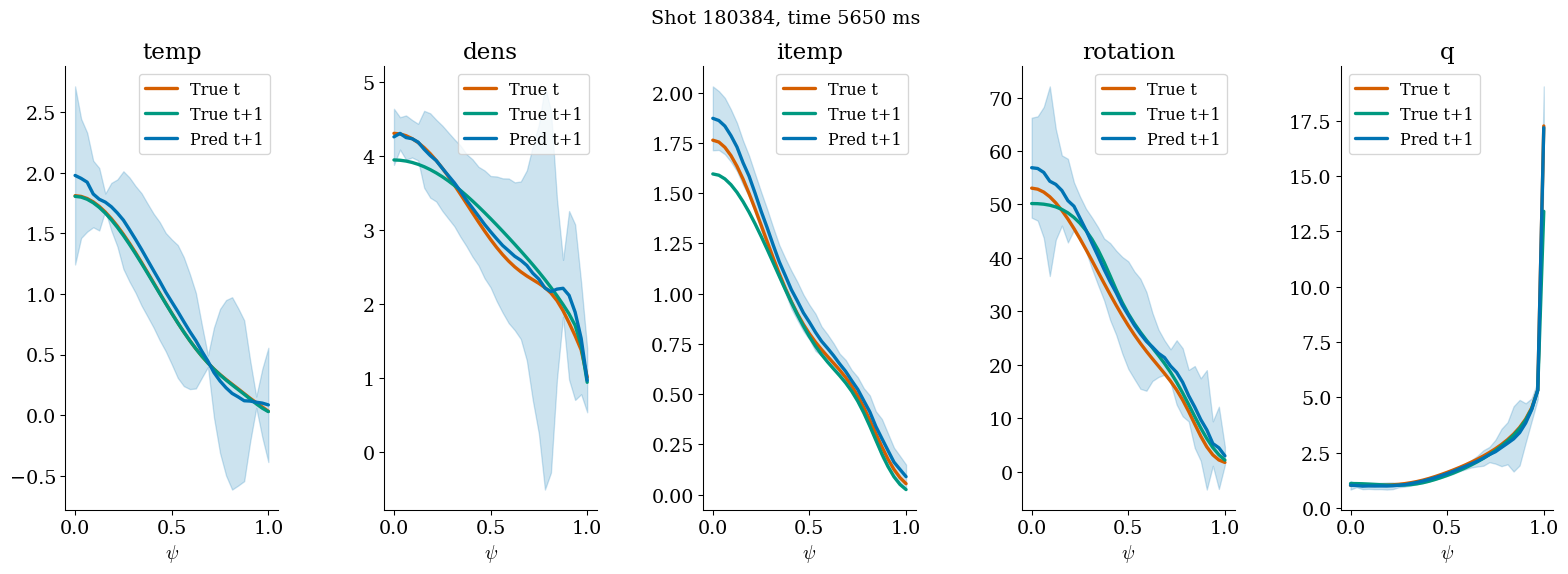

In [56]:
fig, ax = plt.subplots(1,len(profiles),figsize=(20,6))
idx1 = np.random.randint(len(data.keys())-2)
idx2 = np.random.randint(128)
for i, profile in enumerate(profiles):
    baseline = data[idx1]['inputs']['input_'+profile][idx2].squeeze()
    target = data[idx1]['targets']['target_'+profile][idx2].squeeze()
    prediction = data[idx1]['predictions']['target_'+profile][idx2].squeeze()
    uncertainty = data[idx1]['uncertainties']['target_'+profile][idx2].squeeze()
    shotnum = int(data[idx1]['shotnum'][idx2][7])
    shottime = int(data[idx1]['times'][idx2][7])
    
    
    ax[i].plot(psi,denormalize(baseline,scenario['normalization_dict'][profile]),c=colorblind_colors[1],label='True t')
    ax[i].plot(psi,denormalize(baseline+target,scenario['normalization_dict'][profile]),c=colorblind_colors[2],label='True t+1')
    ax[i].plot(psi, denormalize(baseline+prediction,scenario['normalization_dict'][profile]),c=colorblind_colors[0],label='Pred t+1')
    ax[i].fill_between(psi, denormalize(baseline+prediction+uncertainty, scenario['normalization_dict'][profile]), 
                           denormalize(baseline+prediction-uncertainty,scenario['normalization_dict'][profile]),color=colorblind_colors[0],alpha=0.2)    
    
    ax[i].set_title(profile)
    ax[i].set_xlabel('$\psi$')
    ax[i].legend()

fig.suptitle("Shot {}, time {} ms".format(int(shotnum), int(shottime)))
plt.subplots_adjust(wspace=0.5)
# plt.tight_layout()
# fig.savefig('errorbars.png')

In [43]:
c = 0
t = 0
for i in range(86):
    for profile in profiles:
        if 'targets' in data[i] and 'predictions' in data[i] and 'uncertainties' in data[i]:
            err = np.abs(data[i]['targets']['target_'+profile] - data[i]['predictions']['target_'+profile])
            unc = data[i]['uncertainties']['target_'+profile]
            c += np.count_nonzero((unc-err)<0)
            t += unc.size
print(c/t)

0.16916567565186752


In [44]:
baseline_err = {profile:[] for profile in profiles}
baseline_unc = {profile:[] for profile in profiles}
model_err = {profile:[] for profile in profiles}
model_unc = {profile:[] for profile in profiles}
for i in range(86):
    for profile in profiles:
        if 'targets' in data[i] and 'predictions' in data[i] and 'uncertainties' in data[i]:
            mdlerr = np.abs(data[i]['targets']['target_'+profile] - data[i]['predictions']['target_'+profile])
            blerr = np.abs(data[i]['targets']['target_'+profile])
            baseline_err[profile].append(blerr)
            model_err[profile].append(mdlerr)
for profile in profiles:
    baseline_unc[profile] = np.std(np.concatenate(baseline_err[profile],axis=0),axis=0)
    baseline_err[profile] = np.mean(np.concatenate(baseline_err[profile],axis=0),axis=0)
    model_unc[profile] = np.std(np.concatenate(model_err[profile],axis=0),axis=0)
    model_err[profile] = np.mean(np.concatenate(model_err[profile],axis=0),axis=0)

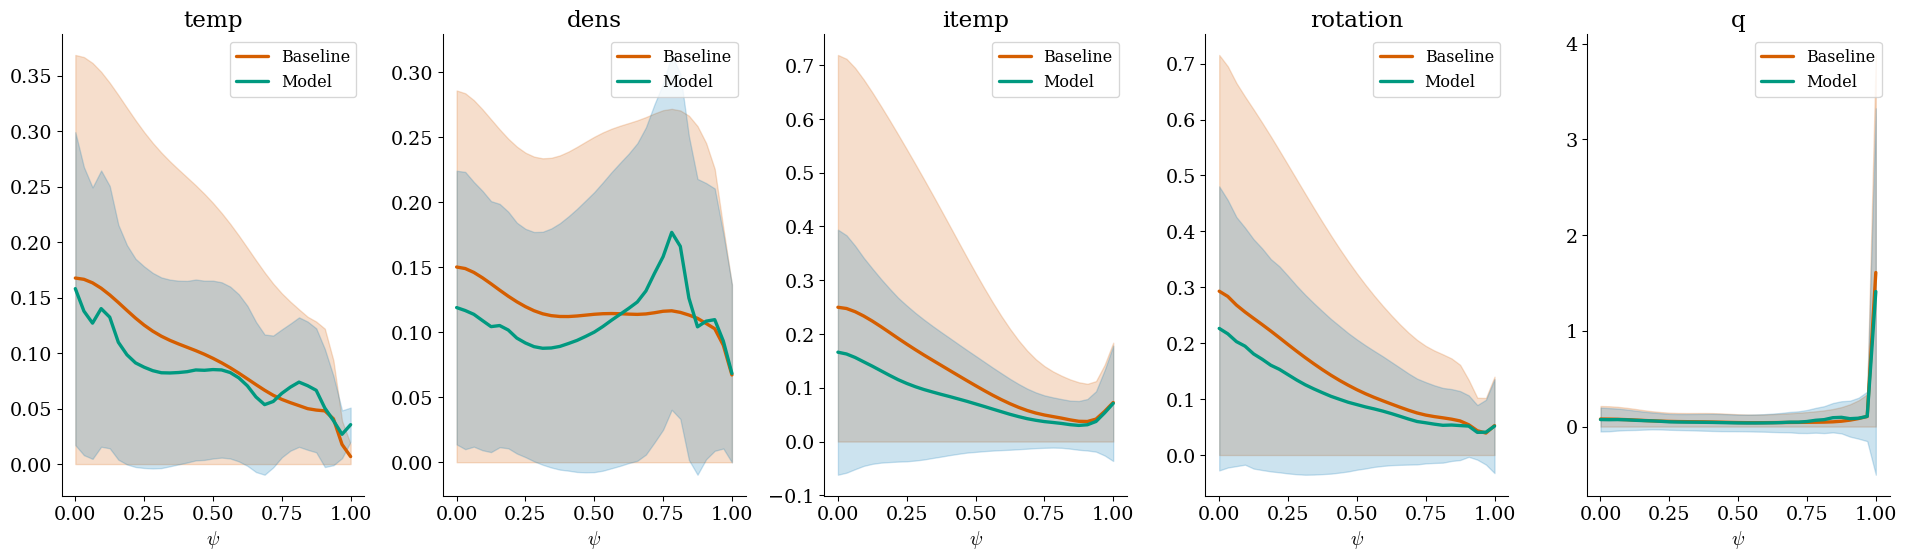

In [45]:
fig, ax = plt.subplots(1,len(profiles),figsize=(20,6))

for i, profile in enumerate(profiles):  
    
    ax[i].plot(psi,baseline_err[profile],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,baseline_err[profile]+baseline_unc[profile],baseline_err[profile]-baseline_err[profile],color=colorblind_colors[1],alpha=0.2)
    ax[i].plot(psi,model_err[profile],c=colorblind_colors[2],label='Model')
    ax[i].fill_between(psi, model_err[profile]+model_unc[profile],model_err[profile]-model_unc[profile], color=colorblind_colors[0],alpha=0.2)    
    
    ax[i].set_title(profile)
    ax[i].set_xlabel('$\psi$')
    ax[i].legend()

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

In [10]:
# file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
# file_path='/home/wconlin/run_results_12_2_real/model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_28Jan20-19-43_Scenario-10.h5'
base_path = os.path.expanduser('~/run_results_01_31/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]
file_path = base_path + files[1]

# model = keras.models.load_model(file_path, compile=False)
# print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded dict: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_31Jan20-16-49_Scenario-6_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weighting', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'scalar_input_names', 'profile_downsample', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'excluded_shots', 'lookbacks', 'sig_names', 'dt', 'normalization_dict', 'profile_length', 'mse_weight_vector', 'date', 'runname',

In [5]:
full_data_oath = '/scratch/gpfs/jabbate/full_data_with_error/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      uncertainties=True)

Loading
Signals: curr_target, dens, density_estimate, itemp, li_EFIT01, pinj, q, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  461
Number of shots used:  461
Total number of timesteps:  53961
Shots with Complete NaN: 
38330 samples total
Removing ECH
Removed 19151 samples
19179 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 2570 samples
16609 samples remaining
Removing weird I-coils
Removed 4980 samples
11629 samples remaining
Removing NaN
Removed 0 samples
11629 samples remaining
Removing dudtrip
Removed 402 samples
11227 samples remaining
11227 samples remaining after pruning
Total number of samples:  11227
Number of training samples:  11227
Number of validation samples:  0


In [6]:
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])

Normalizing: 100%|##########| 27/27 [00:00<00:00, 150.22it/s]


In [7]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std',
                                return_uncertainties=True) #scenario['shuffle_generators'])

In [8]:
profiles = scenario['input_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

In [22]:
index = np.random.randint(len(train_generator))
print(index)
inputs,targets,_,uncertainties = train_generator[index]
base_inputs = copy.deepcopy(inputs)
shotnum = train_generator.cur_shotnum[0,0]
shottime = train_generator.cur_times[0,-scenario['lookahead']-1]

initial_state = {profile: inputs['input_'+profile].squeeze() for profile in profiles}
targets = {key[7:]: val.squeeze() for key,val in targets.items()}
for key,val in inputs.items():
    if val.ndim==2:
        inputs[key] = np.tile(val,(128,1))
    elif val.ndim==3:
        inputs[key] = np.tile(val,(128,1,1))

for profile in profiles:
    if uncertainties[profile]:
        sigma = uncertainties[profile]['input'].squeeze()
        inputs['input_'+profile] += np.random.normal(0,sigma,(128,1,scenario['profile_length']))

9288


In [23]:
predictions = model.predict_on_batch(inputs)
base_pred = model.predict_on_batch(base_inputs)
predictions = {name[7:]:pred.squeeze() for name, pred in zip(model.output_names,predictions)}
base_pred = {name[7:]:pred.squeeze() for name, pred in zip(model.output_names,base_pred)}

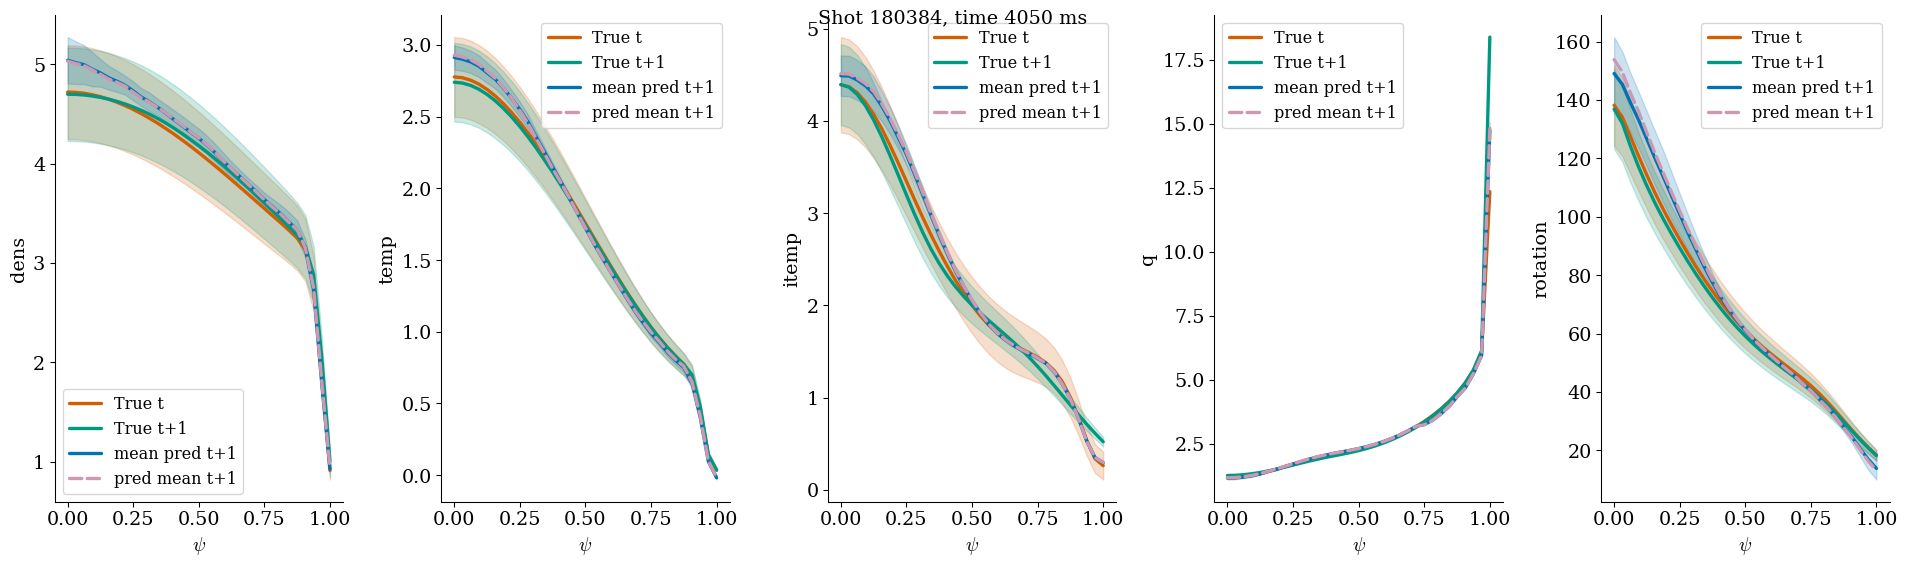

In [24]:
fig, ax = plt.subplots(1,len(profiles),figsize=(20,6))
for i, profile in enumerate(profiles):
    ax[i].plot(psi,denormalize(initial_state[profile],scenario['normalization_dict'][profile]),c=colorblind_colors[1],label='True t')
    ax[i].plot(psi,denormalize(initial_state[profile]+targets[profile],scenario['normalization_dict'][profile]),c=colorblind_colors[2],label='True t+1')
    if uncertainties[profile]:
        s = uncertainties[profile]['input'].squeeze()
        ax[i].fill_between(psi, denormalize(initial_state[profile]-s,scenario['normalization_dict'][profile]), 
                           denormalize(initial_state[profile]+s,scenario['normalization_dict'][profile]),color=colorblind_colors[1],alpha=0.2)    
        s = uncertainties[profile]['target'].squeeze()
        ax[i].fill_between(psi, denormalize(initial_state[profile]+targets[profile]-s,scenario['normalization_dict'][profile]),
                           denormalize(initial_state[profile]+targets[profile]+s,scenario['normalization_dict'][profile]),color=colorblind_colors[2],alpha=0.2)  
        
    m = np.mean(predictions[profile],axis=0)
    s = np.std(predictions[profile],axis=0)
    
    ax[i].plot(psi,denormalize(initial_state[profile]+m,scenario['normalization_dict'][profile]),c=colorblind_colors[0],label='mean pred t+1')
    ax[i].fill_between(psi, denormalize(initial_state[profile]+m-2*s,scenario['normalization_dict'][profile]),
                       denormalize(initial_state[profile]+m+2*s,scenario['normalization_dict'][profile]),color=colorblind_colors[0],alpha=0.2)   
    ax[i].plot(psi,denormalize(initial_state[profile]+base_pred[profile],scenario['normalization_dict'][profile]),c=colorblind_colors[5],linestyle='--',label='pred mean t+1')
    
    ax[i].set_ylabel(profile)
    ax[i].set_xlabel('$\psi$')
    ax[i].legend()

fig.suptitle("Shot {}, time {} ms".format(int(shotnum), int(shottime)))
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
# fig.savefig('errorbars.png')

In [39]:
losses = {'mean_squared_error': keras.losses.mean_squared_error,
          'mean_absolute_error': keras.losses.mean_absolute_error,
          'normed_mse': normed_mse,
          'mean_diff_sum_2': mean_diff_sum_2,
          'max_diff_sum_2': max_diff_sum_2, 
          'mean_diff2_sum2': mean_diff2_sum2, 
          'max_diff2_sum2': max_diff2_sum2}

In [48]:
ensemble_evaluation_metrics = {}
for profile in model.output_names:
    for metric in losses.keys():
        ensemble_evaluation_metrics[profile+'_'+metric] = []

nsamples = 100
for index in tqdm(np.random.randint(low=0,high=len(train_generator),size=nsamples)):
    inputs,targets,_,uncertainties = train_generator[index]

    for key,val in inputs.items():
        if val.ndim==2:
            inputs[key] = np.tile(val,(128,1))
        elif val.ndim==3:
            inputs[key] = np.tile(val,(128,1,1))

    for profile in profiles:
        if uncertainties[profile]:
            sigma = np.abs(uncertainties[profile]['input'].squeeze())
            inputs['input_'+profile] += np.random.normal(0,sigma,(128,1,scenario['profile_length']))

    predictions = model.predict_on_batch(inputs)
    predictions = {name:np.mean(pred,axis=0).squeeze() for name, pred in zip(model.output_names,predictions)}
    
    for profile in model.output_names:
        for name, metric in losses.items():
            ensemble_evaluation_metrics[profile+'_'+name].append(K.eval(metric(targets[profile],predictions[profile]))) 

for key,val in ensemble_evaluation_metrics.items():
    ensemble_evaluation_metrics[key] = np.mean(val)
        
            



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:17<28:18, 17.15s/it]

  2%|▏         | 2/100 [00:34<27:58, 17.13s/it]

  3%|▎         | 3/100 [00:51<27:56, 17.28s/it]

  4%|▍         | 4/100 [01:09<27:58, 17.48s/it]

  5%|▌         | 5/100 [01:28<28:02, 17.71s/it]

  6%|▌         | 6/100 [01:46<28:05, 17.93s/it]

  7%|▋         | 7/100 [02:05<28:09, 18.17s/it]

  8%|▊         | 8/100 [02:24<28:14, 18.42s/it]

  9%|▉         | 9/100 [02:43<28:14, 18.62s/it]

 10%|█         | 10/100 [03:02<28:21, 18.90s/it]

 11%|█         | 11/100 [03:22<28:27, 19.18s/it]

 12%|█▏        | 12/100 [03:42<28:34, 19.48s/it]

 13%|█▎        | 13/100 [04:03<28:38, 19.76s/it]

 14%|█▍        | 14/100 [04:23<28:35, 19.95s/it]

 15%|█▌        | 15/100 [04:44<28:43, 20.28s/it]

 16%|█▌        | 16/100 [05:06<28:49, 20.59s/it]

 17%|█▋        | 17/100 [05:27<28:53, 20.89s/it]

 18%|█▊        | 18/100 [05:49<28:57, 21.19s/it]

 19%|█▉        | 19/100 [06:11<28:56, 21.44s/it]

 20%|██        |

In [50]:
for metric in metrics:
    name = metric if isinstance(metric,str) else str(metric.__name__)
    print(name)
    s = 0
    for key,val in ensemble_evaluation_metrics.items():
        if name in key:
            s += val/len(model.outputs)
    print(s)
    ensemble_evaluation_metrics[name] = s

mean_squared_error
0.07767946608364582
normed_mse
14801.20496531725
mean_diff_sum_2
0.5445669889450073
max_diff_sum_2
0.9635934591293335
mean_diff2_sum2
0.4534062385559082
max_diff2_sum2
0.5092709064483643


In [52]:
optimizer = keras.optimizers.Adam()
loss = keras.metrics.mean_squared_error
metrics = [keras.metrics.mean_squared_error, keras.metrics.mean_absolute_error, normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2]
model.compile(optimizer, loss, metrics)

regular_generator = DataGenerator(traindata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std',
                                return_uncertainties=False) #scenario['shuffle_generators'])

outs = model.evaluate_generator(regular_generator, verbose=1, workers=8, use_multiprocessing=True)


regular_evaluation_metrics = {name: val for name,val in zip(model.metrics_names,outs)}
for metric in metrics:
    name = metric if isinstance(metric,str) else str(metric.__name__)
    print(name)
    s = 0
    for key,val in regular_evaluation_metrics.items():
        if name in key:
            s += val/len(model.outputs)
    print(s)
    regular_evaluation_metrics[name] = s

88/88 [==============================] - 29s 335ms/step
mean_squared_error
0.07638969286415871
mean_absolute_error
0.11389455943204706
normed_mse
107202.76036543662
mean_diff_sum_2
0.5413923634689192
max_diff_sum_2
0.9692386582144712
mean_diff2_sum2
0.4611940336750888
max_diff2_sum2
0.5193310070260291


In [4]:
base_path = os.path.expanduser('~/')
folders = ['run_results_01_28/','run_results_01_30/','run_results_01_31/','run_results_02_06/']

profiles = ['temp','dens','itemp','rotation','q']
actuators = ['target_density', 'pinj', 'tinj', 'curr_target']
scalars = ['density_estimate', 'li_EFIT01', 'volume_EFIT01', 'triangularity_top_EFIT01', 'triangularity_bot_EFIT01']
scenarios = []
model_paths = []
for folder in folders:
    files =  [foo for foo in os.listdir(base_path+folder) if foo.endswith('.pkl')]
    for file in files:
        file_path = base_path + folder + file
        with open(file_path, 'rb') as f:
            scenario = pickle.load(f, encoding='latin1')
        if set(scenario['input_profile_names']) == set(profiles) and \
        set(scenario['target_profile_names']) == set(profiles) and \
        set(scenario['actuator_names']) == set(actuators) and \
        set(scenario['scalar_input_names']) == set(scalars):
            scenarios.append(scenario)
            model_path = file_path[:-11] + '.h5'
            model_paths.append(model_path)
scenario = scenarios[0]

In [5]:
models = []
for model_path in tqdm(model_paths[:2]):
    model = keras.models.load_model(model_path, compile=False)
    models.append(model)

100%|██████████| 2/2 [05:34<00:00, 167.10s/it]


In [6]:
full_data_oath = '/scratch/gpfs/jabbate/full_data_with_error/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      uncertainties=False)

Loading
Signals: curr_target, dens, density_estimate, itemp, li_EFIT01, pinj, q, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  461
Number of shots used:  461
Total number of timesteps:  53961
Shots with Complete NaN: 
38330 samples total
Removing ECH
Removed 19151 samples
19179 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 2570 samples
16609 samples remaining
Removing weird I-coils
Removed 4980 samples
11629 samples remaining
Removing NaN
Removed 0 samples
11629 samples remaining
Removing dudtrip
Removed 402 samples
11227 samples remaining
11227 samples remaining after pruning
Total number of samples:  11227
Number of training samples:  11227
Number of validation samples:  0


In [7]:
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
psi = np.linspace(0,1,scenario['profile_length'])

Normalizing: 100%|##########| 23/23 [00:00<00:00, 132.50it/s]


In [8]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std',
                                return_uncertainties=False) #scenario['shuffle_generators'])

In [9]:
losses = {'mean_squared_error': keras.losses.mean_squared_error,
          'mean_absolute_error': keras.losses.mean_absolute_error,
          'normed_mse': normed_mse,
          'mean_diff_sum_2': mean_diff_sum_2,
          'max_diff_sum_2': max_diff_sum_2, 
          'mean_diff2_sum2': mean_diff2_sum2, 
          'max_diff2_sum2': max_diff2_sum2}
ensemble_evaluation_metrics = {}
for profile in model.output_names:
    for metric in losses.keys():
        ensemble_evaluation_metrics[profile+'_'+metric] = []

In [ ]:
import time
t0 = time.time()
for index in range(len(train_generator)):
    inputs,targets,_ = train_generator[index]
    predictions = []
    for j, model in enumerate(models):
        pred = model.predict_on_batch(inputs)
        predictions.append(pred)
    predictions = np.mean(predictions,axis=0)
    predictions = {name:p for name, p in zip(model.output_names,predictions)}

    
    for profile in model.output_names:
        for name, metric in losses.items():
            ensemble_evaluation_metrics[profile+'_'+name].append(K.eval(metric(targets[profile],predictions[profile]))) 

for key,val in ensemble_evaluation_metrics.items():
    ensemble_evaluation_metrics[key] = np.mean(val)
print(time.time()-t0)
            

In [34]:
for metric in losses:
    name = metric if isinstance(metric,str) else str(metric.__name__)
    s = 0
    for key,val in ensemble_evaluation_metrics.items():
        if name in key:
            s += val/len(model.outputs)
    ensemble_evaluation_metrics[name] = s

for key, val in ensemble_evaluation_metrics.items():
    print('{}: {:.3e}'.format(key,val))

target_dens_mean_squared_error: 4.362e-02
target_dens_mean_absolute_error: 1.667e-01
target_dens_normed_mse: 1.068e-01
target_dens_mean_diff_sum_2: 1.381e-01
target_dens_max_diff_sum_2: 9.655e-01
target_dens_mean_diff2_sum2: 7.739e-02
target_dens_max_diff2_sum2: 1.117e-01
target_temp_mean_squared_error: 8.043e-02
target_temp_mean_absolute_error: 2.286e-01
target_temp_normed_mse: 1.409e-01
target_temp_mean_diff_sum_2: 1.959e-01
target_temp_max_diff_sum_2: 8.650e-01
target_temp_mean_diff2_sum2: 1.855e-01
target_temp_max_diff2_sum2: 2.759e-01
target_itemp_mean_squared_error: 1.220e-01
target_itemp_mean_absolute_error: 2.944e-01
target_itemp_normed_mse: 1.484e-01
target_itemp_mean_diff_sum_2: 1.239e-01
target_itemp_max_diff_sum_2: 5.694e-01
target_itemp_mean_diff2_sum2: 8.550e-02
target_itemp_max_diff2_sum2: 1.519e-01
target_q_mean_squared_error: 2.542e-02
target_q_mean_absolute_error: 1.172e-01
target_q_normed_mse: 2.235e-01
target_q_mean_diff_sum_2: 5.522e-01
target_q_max_diff_sum_2: 1.0